# by @sol2man2

# 3.1 An example statistical model

<img src="./figures/disasterts.png">

* 초기에는 포아송 분포의 높은 비율로 시작해서 후반부에는 비율이 낮아짐.
* 우리는 시계열에서 중간에 변경된 지점에 관심이 있음.

<img src="./figures/3.1equation.png">

# 3.2 Two types of variables

* 베이지안은 확률을 지식이나 인지로 본다.
* 지식과 불확실의 표현으로 보는 거지
* 우리가 알고 있는 범위에서 p(x)가 높은 x는 발현할 확률이 높다는 뜻
* 확률변수는 PyMC에서 Stocastic하고 Deterministic한 클래스로 표현된다.
* r은 Deterministic
* (s,l,e)는 r의 부모라면 r을 계산할 수 있다.
* r과 같은 Deterministic은 부모의 값으로 제공된 값을 반환하는 수학적 함수에 의해 정의된다.
* Deterministic var를 **모델의 systemic part**라한다.
* 이름 자체가 확률변수를 말하기 땜에 이름 자체가 조금 혼란스러움.
* r의 부모가 랜덤이면 r도 랜덤임. 
* 어색하긴하지만 이 클래스의 이름은 DeterminedByValuesOfParents.
* 다른 말로 하면 switchpoint 변수의 부모의 값이 early_mean이나 late_mean으로 알려졌지만 여전히 변수는 불확실하다.
* 이런 변수는 후보 값이 얼마나 그럴듯한지를 표현하는 확률 분포에 의해 특징지어 진다.
* Stochastic 클래스는 이런 변수를 표현한다. 이 객체를 더 잘 서술한 이름이 RandomEvenGivenValuesOfParents이다.
* disaster_model.py에 모델을 표현할 수 있다.

In [1]:
from pymc import DiscreteUniform, Exponential, Deterministic, Poisson, Uniform
import numpy as np
import disaster_model

Couldn't import dot_parser, loading of dot files will not be possible.


* pymc에서 특별한 모델을 의해 선택된 객체를 수입할 수 있다.

In [2]:
disasters_array =   \
     np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

disaster_model.py에 다 있으니 추가해서 사용하시오

In [3]:
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, doc='Switchpoint[year]')

* DiscreteUniform은 유니폼 분포의 이산 변수를 나타내는 Stochastic의 하위 클래스이다.
* 이 분포를 사용하는 건 switchpoint에 따라 선호하는 a priori가 없단 얘기지.
* 모든 값은 발생률이 같다.
* 지금 포아송 비률을 위해 지수분포 변수 early_mean과 late_mean을 각각 생성한다.

In [4]:
early_mean = Exponential('early_mean', beta=1.)
late_mean = Exponential('late_mean', beta=1.)

다음으로
* switchpoint를 전후하여 early_mean과 late_mean의 변수 률(rate)을 정의한다.
* 파이선의 일반 함수 rate를 Deterministic 객체로 변환하는 deterministic decorator를 사용하여 rate를 생성한다.

In [5]:
@deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out

NameError: name 'deterministic' is not defined

* 다음 단계는 disasters의 수 정의하기다.
* 이 수치는 stochastic 변수지만 switchpoint, early_mean, late_mean과는 달리 그 값을 관찰한다.
* 이걸 설명하기 위해서 observed를 True로 설정한다. (기본은 False)
  * pymc에게 객체의 값이 변경되지 않아야 함을 주문한다.

In [6]:
disasters = Poisson('disasters', mu=rate, value=disasters_array, observed=True)

NameError: name 'rate' is not defined

## 3.2.1 Why are data and unknown variables represented by the same object?

* disasters가 Stochastic 객체로 표현되었기에 그 값이 고정이더라도 부모의 률에 종속적으로 정의된다.
* 베이지안 계층 표기법 자체가 확률변수와 데이터 사이에 구분을 만들지 않는다.
* 이유는 간단한데 모델의 사후 확률인 p(e,s,l|D)를 계산해서 베이지안 이론을 사용하기 위해선 가능도인 p(D|e,s,l)이 필요하다.
* disasters의 값이 알려져 있고 고정되어 있지만 요넘이 확률 변수인 것처럼 확률 분포를 정의할 필요가 있다.
* 가능도가 파라미터의 함수로 여겨지고 확률 함수는 데이터의 함수로 간주된다는 건만 제외하곤 둘(가능도와 확률함수)은 근본적으로 같다는 것을 상기하자.
* 사람들의 본능은 데이터에 의존하는 만큼만 데이터를 고정된 사전 확률과 알려지지 않은 변수로 간주하듯이 이 점이 최초 직관에 반할 수 있다. 
* 통계적 모델을 데이터에 대한 예측 모델이나 데이터가 발생하는 프로세스의 모델로 치는 것도 한가지 방법이 될 수 있다.
* disasters의 값을 관측하기 전에 우리는 사전 예측 확률p(D)에서 표집할 수 있다.
  * Sample early_mean, switchpoint and late_mean from their priors.
  * Sample disasters conditional on these values.

우리가 disasters를 관측한 이후에나 이 관측 정보가 변수와 어떻게 관련이 있는지에 확인할 수 있는 정보이기 때문에 early_mean, switchpoint, late_mean에 대해 추론하기 위해서 이런 프로세스 모델을 사용할 필요가 생긴다.

# 3.3 Parents and children

* 단순히 변수와 링크된 집단인 위의 PyMC 확률 모델을 생성한다.
* 링크의 본성을 보기 위해선 disaster_model.py를 수입하여 돌려라.
* 파이선 프롬프트에서 switchpoint의 parents를 평가해라.

In [7]:
from pymc.examples import disaster_model
disaster_model.switchpoint.parents

{'lower': 0, 'upper': 110}

* parents 디렉토리는 상수인 switchpoint의 분포의 파리미터를 보여준다.
* 지금 disasters의 parents예를 보자.

In [8]:
disaster_model.disasters.parents

{'mu': <pymc.PyMCObjects.Deterministic 'rate' at 0x7fd2d1403610>}

* rate를 disasters의 분포 파라미터로 사용한다.
* rate를 disasters의 포아송 분포에서 rate 파라미터 역할을 하는 의미에서 disasters는 내부적으로 rate를 mu로 레이블한다.
* 바로 rate의 children 속성을 평가해 보자

In [9]:
disaster_model.rate.children

{<pymc.distributions.Poisson 'disasters' at 0x7fd2d1403750>}

* disasters는 rate를 부모로 섬기기 때문에 rate는 disaster를 새끼로 키운다.
* parents와 달리 children은 무순위의 객체 집단의 집합이다.
* 변수는 특별한 분포적 역할을 담당하는 그들의 자식과 연관되지 않는다.
* 모델에 다른 파라미티의 parents와 children 속성을 평가해 보라.

* 아래의 방향성 비순환성 그래프는 모델에서 parent-child 관계의 가시화이다.
* 관측되지 않은 stochastic 변수인 stochastic switchpoint, early_mean, late_mean들은 타원으로, 관측된 stochastic 변수인 disasters는 채워진 타원으로, deterministic 변수인 rate는 삼각형으로 표현된다.
* 부모와 자식의 관계는 화살표로 나타내고 부모에 할당된 자식은 레이블로 표시한다.
* Graphing models을 상세히 보자(4장에 있음)

<img src='./figures/DisasterModel2.png'>

석탄광 재난 모델 예에서 방향을 갖는 비순환 관계 그래프이다.

위 예에서 보듯이 pymc 객체는 switchpoint, early_mean, late_mean처럼 이름이 정해져야 한다. 이 이름은 저장과 사후 처리를 위해 사용된다.

* as keys in on-disk databases,
* as node labels in model graphs,
* as axis labels in plots of traces,
* as table labels in summary statistics.

동일한 이름을 갖는 변수로 인스턴스된 모델은 이름 충돌을 피하기 위해 db저장 추적시에 err을 낸다. 그러나 일반적으로 pymc는 변수를 식별하기 위해서 객체 자체의 참조를 사용하지 이름을 사용하진 않는다.

# 3.4 Variables' values and log-probabilities

* PyMC변수는 변수의 현재값을 저장하는 value라 불리는 속성을 갖는다. 
* disasters의 value를 평가해 봐라 그러면 초기값을 볼 수 있다.

In [10]:
disaster_model.disasters.value

array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1,
       4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3,
       0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2,
       0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

switchpoint, early_mean, late_mean의 값을 확인하면 PyMC가 생성한 랜덤 초기값을 볼 수 있다.

In [11]:
disaster_model.switchpoint.value

array(24)

In [13]:
disaster_model.early_mean.value

array(0.36637928740655185)

In [14]:
disaster_model.late_mean.value

array(1.3932648279262168)

* 물론 이들이 stochastic 요소이기 때문에 실제 값은 이들과 다를 것이다.
* rate의 value를 확인하면 첫째 배열의 switchpoint요소가 early_mean이고 이후가 late_mean임을 확인할 수 있다.

In [15]:
disaster_model.rate.value

array([ 0.36637929,  0.36637929,  0.36637929,  0.36637929,  0.36637929,
        0.36637929,  0.36637929,  0.36637929,  0.36637929,  0.36637929,
        0.36637929,  0.36637929,  0.36637929,  0.36637929,  0.36637929,
        0.36637929,  0.36637929,  0.36637929,  0.36637929,  0.36637929,
        0.36637929,  0.36637929,  0.36637929,  0.36637929,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39326483,
        1.39326483,  1.39326483,  1.39326483,  1.39326483,  1.39

* 이 값을 계산하기 위해서 rate는 부모의 값에 넘기는 우리가 만든 함수를 호출한다.

* Stochastic 객체는 부모의 값에 의한 현재 값에서 그들의 확률 질량 함수나 확률 밀도 함수를 평가할 수 있다.
* Stochastic 객체의 확률 질량/밀도 함수의 로그치는 logp 속성으로 접근할 수 있다.
* disasters 같은 벡터 벨류 변수를 위해서는 logp 속성은 모든 값 인자의 결합 확률이나 밀도의 로그 합을 반환한다.
* switchpoint의, disasters의 로그 확률과 early_mean의, late_mean의 로그 밀도를 평가해 봐라.

In [16]:
disaster_model.switchpoint.logp

-4.709530201312334

In [17]:
disaster_model.disasters.logp

-284.3224944872588

In [18]:
disaster_model.early_mean.logp

-0.36637928740655185

In [19]:
disaster_model.late_mean.logp

-1.3932648279262168

* rate가 그 값을 계산하기 위해 내부 함수를 호출하듯이, Stochastic 객체는 logp속성을 계산하는 내부 함수를 호출할 필요가 있다.
* 값을 계산하기 위해 함수를 치장하여 rate를 생성했듯이, 로그 확률과 밀도를 계산하는 함수를 치장하여 커스텀 Stochastic 객체를 생성하는 것도 가능하다.
* 사용자는 PyMC에서 제공하는 통계적 분포의 집합에 제한되지 않는다.

## 3.4.1 Using Variables as parents of other Variables

rate에 대한 우리의 정의를 밀착해서 보자

In [20]:
@deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out

NameError: name 'deterministic' is not defined

* switchpoint, early_mean, late_mean은 stochastic 객체이지 수치가 아니다.
* 만약 수치라면 우리가 배열 out을 stochastic 객체에 썰어 넣을 때 오류가 안나겠는가?

* 변수는 자식변수를 위한 부모 변수로 쓰일 때마다 자식 값이나 log 확률이 계산되는 순간 PyMC는 변수를 값의 속성을 교체한다.
* rate 값이 재계산되면 s.value는 switchpoint 형태로 함수에 전달된다.
* rate의 부모의 값을 한꺼번에 보려면 rate.parents.value를 봐라.

# 3.5 Fitting the model with MCMC

* PyMC는 우리가 지금까지 했던 것처럼 확률 모델을 적합하는 여러가지 객체를 제공한다.
* MCMC같은 으뜸 객체는 MCMC알고르즘과 함께 모델을 적합한다.
* 우리 모델을 조작하는 MCMC 객체를 생성하려면 disaster_model.py를 수입해고 MCMC의 아규멘트로 사용해라.

In [21]:
from pymc.examples import disaster_model
from pymc import MCMC
M = MCMC(disaster_model)

* 이 경우 M은 switchpoint, early_mean, late_mean, disasters 변수를 속성으로 노출한다. M.switchpoint는 disaster_model.switchpoint와 같다.

* 샘플러를 돌리기 위해 iterations 수, burn-in 길이, thining interval을 아규먼트로 해서 MCMC객체의 sample()를 호출해라.

In [22]:
M.sample(iter=10000, burn=10000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.6 sec

수초 후에 표본이 정상적으로 추출됨을 볼 수 있다 모델이 적합된 거다.

## 3.5.1 What does it mean to fit a model?

* 모델을 접합한다는 의미는 모델의 사후 분포를 특성짓는 것이다.
* 이경우 사후 분포는 결합 표본의 집합에 의해 p(s,e,l|D)로 표현한다.
* 이 표본을 만들려면 MCMC 샘플러는 메트로폴리스 하스팅 알고르즘에 의해 switchpoint, early_mean, late_mean의 값을 무작위로 갱신한다.

* 샘플의 수가 충분히 크게 증가할수록 switchpoint, early_mean, late_mean 의 MCMC 분포는 결합의 정적인 분포로 수렴한다.
* 다시말해 그 값들은 사후 분포 p(s,e,l|D)에서 무작위 추첨으로 간주된다.
* PyMC는 알고리즘이 수렴하기 때문에 burn 파라미터가 충분히 큰 반복 수치임을 명시한다. 그리하여 이런 경우를 사용자가 검증하기에 달려 있다.
* switchpoint, early_mean, late_mean에서 표본된 연속된 값들은 마르코브 체인이기 때문에 항상 시리얼하게 종속이다.
* MCMC는 종종 정밀하지 않은  사후 추론을 결정짓는 샘플 간에 강한 자기상관성을 보인다.
* 이를 피하려고 매 k번째(k는 정수임) 샘플을 유지하여 샘플을 얇게 가져가는 것이 유용하다.
* thin 아규먼트를 통해 얇은 간격이 샘플러에게 넘겨진다.

* burn과 thin의 파라미터로 값을 선택하기에 앞서 확인하지 않았다면 burn=0, thin=1로 설정하여 MCMC샘플러 모두를 유지하길 원할 거다.
* 추적을 평가하고는 burn-in period와 샘플을 thin하게 만드는 것을 버려라.

## 3.5.2 Accessing the samples

* MCMC 알고리즘의 결과는 각 변수마다 남아 있는 일련의 샘플들인 추적기록이다. 
* 이 추적기록은 trace(name, chain=-1) 메소드를 통해 접근할 수 있다.

In [23]:
M.trace('switchpoint')[:]

array([0])

* 추적기록의 슬라이스 [start:stop:step]는 NumPy의 배열 슬라이스처럼 동작한다.
* 기본값으로  반환 추적기록 배열은 sampl의 마지막 호출에서 추출한 샘플을 가진다.
* 하지만 이전 샘플링의 추적기록은 대응되는 chain index를 명시하여 복원할 수 있다.
* 모든 chain에서 추적 기록을 반환받으려면 chain=None으로 설정해라.

## 3.5.3 Sampling output

* 추적기록의 히스토그램을 그림으로써 변수의 마지널 사후분포를 평가할 수 있다.

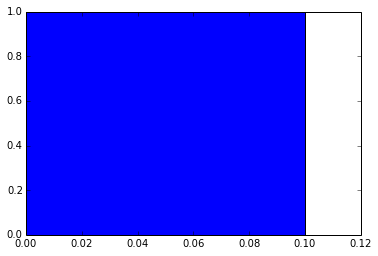

In [24]:
%matplotlib inline
from pylab import hist, show
hist(M.trace('late_mean')[:])
show()

<img src='./figures/ltrace.png'>

late_mean 파라미터의 마지널 사후 확률의 히스토그램.

* PyMC는 matplotlib를 통해서 자신만의 그림 그리는 기능을 가진다.
* Matplot 모듈은 모델을 아규먼트로 취하는 plot 함수를 포함한다.

Plotting switchpoint
Cannot plot autocorrelation for switchpoint
Plotting early_mean
Cannot plot autocorrelation for early_mean
Plotting late_mean
Cannot plot autocorrelation for late_mean


/usr/lib/pymodules/python2.7/matplotlib/axes.py:4511: RuntimeWarning: invalid value encountered in true_divide
  c /= np.sqrt(np.dot(x, x) * np.dot(y, y))


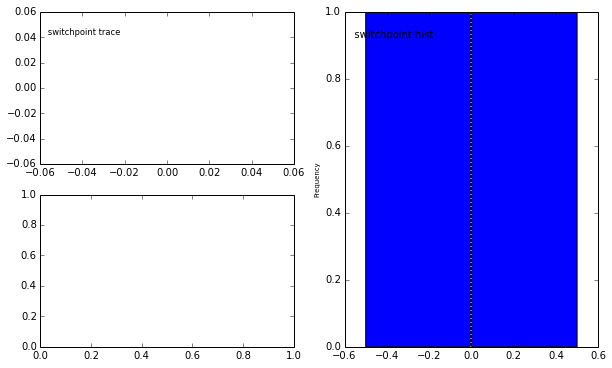

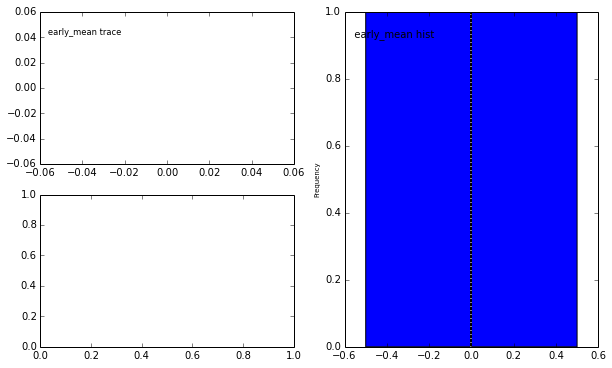

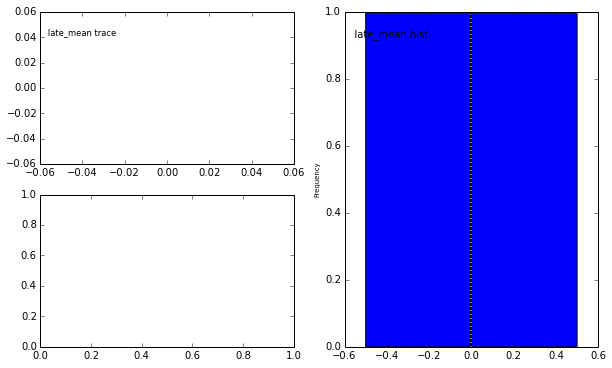

In [25]:
from pymc.Matplot import plot
plot(M)

<img src='./figures/spost.png'>

switchpoint를 위한 임시 시리즈, 자기상관 그림과 히스토 그램을 그린다.

* 좌측 상단은 switchpoint에서 추출한 샘플의 임의의 시리즈를 보여준다.
* 반면 아래는 샘플의 자기 상관 그림을 보여 준다.
* 우측은 추적기록의 히스토 그램을 보여 준다.
* 히스토그램은 사후 확률을 가시화 하는데 유용한 반면 추적기록은 알고리즘 성능을 평가하고 진단하는데 유용하다

사후 확률의 비 그래프적인 요약은 단지 M.stats()를 호출해라.

In [26]:
M.stats()

Could not generate output statistics for switchpoint
Could not generate output statistics for early_mean
Could not generate output statistics for late_mean


{'early_mean': None,
 'late_mean': None,
 'rate': {'95% HPD interval': array([ 0.,  0.]),
  'mc error': 0.0,
  'mean': 0.0,
  'n': 111,
  'quantiles': {2.5: 0.0, 25: 0.0, 50: 0.0, 75: 0.0, 97.5: 0.0},
  'standard deviation': 0.0},
 'switchpoint': None}

## 3.5.4 Imputation of Missing Data

* 대부분 교재의 예제처럼 지금까지 우리가 평가한 모델들은 연관된 데이터가 완벽하다고 가정한다.
* 데이터집합 상에 관측치에 누락은 없다.
* 하지만 많은 실데이터 집합은 데이터 수집 과정의 물류 문제로 누락된 관측이 존재한다.
* 누락치를 포함하는 관측을 다루는 초기 방법은 분석에서 걍 배제하는 거다.
* 하지만 배제된 정보가 다른 정보에 비해 가용한 값을 포함했을 땐 이는 정보 손실로 이어지고 결과에 편의를 가져온다.
* 대안으로 모델의 마지막 부분에 정보에 기반하여 누락치를 전가하는 방법이다.

|Count|Site|Observer|Temperature|
|-|-|-|-|
|15|1|1|15|
|10|1|2|NA|
|0|1|1|15|

* 각 행은 서베이 과정에서 세개의 공변량과 함께 나온 개개인의 수를 포함한다. 
* 서베이가 진행된 site, 데이터를 수집한 관측자, 서베이 동안 온도
* 숫자 기능으로 인구 규모와 연계된 공변량을 모델링하는데 관심있다면 온도가 누락되었기 때문에 두번째 관측을 수용하기는 어렵다.
* 이 관측을 무시하면 우리기 모델을 적합할 수 있지만 다른 공변량에 포함된 정보를 낭비하게 된다.

* 베이지안 모델링 프래임워크에서 누락 정보를 미지의 모델 파라미터로 취급하여 간단하게 수용한다.
* 누락 데이터 ~y의 값은 사후 예측 분포를 사용하여 자연스레 추정된다.

<img src='./figures/3.5equation.png'>

* 이것은 데이터 ~y를 관측되지 않는 데이터나 미래의 잠재 관측치로 기술한다.
* 누락 데이터의 값을 모델링하는 사후 예측 분포를 사용할 수 있다.

* 이전에 소개된 석탄광 재난 데이터를 고래해 보라.
* 시계열에서 두 해분이 누락되었다.
* 데이터 배열에서 이 데이터를 임의의 자리값을(None) 사용했다.

In [27]:
x = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, None, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, None, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

* PyMC에서 이 값을 추정하려면 마스크 배열을 만든다.
* 이는 각 값이 계산에서 배제되는지 맞춰 보는 True/False 값을 포함하는 특화된 NumPy 배열이다.
* 마스크 배열은 NumPy의 ma.masked_equal함수로 생성할 수 있다.

In [28]:
masked_values = np.ma.masked_equal(x, value=None)

In [29]:
masked_values

masked_array(data = [4 5 4 0 1 4 3 4 0 6 3 3 4 0 2 6 3 3 5 4 5 3 1 4 4 1 5 5 3 4 2 5 2 2 3 4 2
 1 3 -- 2 1 1 1 1 3 0 0 1 0 1 1 0 0 3 1 0 3 2 2 0 1 1 1 0 1 0 1 0 0 0 2 1 0
 0 0 1 1 0 2 3 3 1 -- 2 1 1 1 1 2 4 2 0 0 1 4 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False],
       fill_value = ?)

* 이 마스크 배열은 마스크 배열을 인식하여 누락 값을 Stochastic 별수로 바꾸는 PyMC의 데이터 stochastic 변수에 전달된다.
* 석탄광 재난 문제를 위해 재난사고는 포아송 변량으로 모델링 됨을 회상하라

In [30]:
from pymc import Poisson
disasters = Poisson('disasters', mu=rate, value=masked_values, observed=True)

NameError: name 'rate' is not defined

* rate는 switchpoint의 위치에 따른 년간 데이터의 평균 배열이다.
* 누락 값이 non data stochastic인 반면 재난의 각 요소는 관측치가 있건 없건 포아송 stochastic이다.
* 후자는 고정된 정보가 아닌 미지의 정보이고 미지의 모델 파라미터처럼 MCMC 알고리즘으로 추정된다.

전체 모델은 원 모델에 매우 유사해 보인다.

In [32]:
# Switchpoint
switch = DiscreteUniform('switch', lower=0, upper=110)
# Early mean
early_mean = Exponential('early_mean', beta=1)
# Late mean
late_mean = Exponential('late_mean', beta=1)

@deterministic(plot=False)
def rate(s=switch, e=early_mean, l=late_mean):
    """Allocate appropriate mean to time series"""
    out = np.empty(len(disasters_array))
    # Early mean prior to switchpoint
    out[:s] = e
    # Late mean following switchpoint
    out[s:] = l
    return out


# The inefficient way, using the Impute function:
# D = Impute('D', Poisson, disasters_array, mu=r)
#
# The efficient way, using masked arrays:
# Generate masked array. Where the mask is true,
# the value is taken as missing.
masked_values = masked_array(disasters_array, mask=disasters_array==-999)

# Pass masked array to data stochastic, and it does the right thing
disasters = Poisson('disasters', mu=rate, value=masked_values, observed=True)

NameError: name 'deterministic' is not defined

* 여기서 우리는 masked_equal함수보다는 masked_array 함수를 사용했다.
* 누락값으로 -999를 배정했고 결과는 다음과 같다

<img src='./figures/missing.png'>

누락 자료의 추적기록, 자기상관도와 사후 분포의 예이다.

# 3.6 Fine-tuning the MCMC algorithm

* MCMC 객체는 MCMC 알고리즘의 각 단계에서 파라미터를 어떻게 변경할지를 결정하는 step 메소드를 통해 개별 변수를 다룬다.
* 기본값으로 step 메소드는 자동적으로 PyMC에 의해 변수에 할당된다.
* M이 사용하는 step 메소드를 보려면 step_method_dict 속성을 봐라.

In [34]:
M.step_method_dict[disaster_model.switchpoint]

In [35]:
M.step_method_dict[disaster_model.early_mean]

In [36]:
M.step_method_dict[disaster_model.late_mean]

* 특별한 변수에 대응하는 step_method_dict의 값은 M이 변수를 다루기 위해 사용하는 step 메소드의 리스트이다.

* M.use_step_method를 호출하여 M이 특별한 step 메소드를 사용하게 할 수 있다.
* 다음의 콜은 M이 표준 메트로폴리스 step 메소드를 써서 late_mean을 다르게 만든다.

In [39]:
from pymc import Metropolis
M.use_step_method(Metropolis, disaster_model.late_mean, proposal_sd=2.)

* 다른 step 메소드인 AdaptiveMetropolis는 높은 상관성의 변수를 다루는데 탁월하다.
* 만일 모델이 조잡하게 섞여 있다면 AdaptiveMetropolis를 초기 사용은 감각적인 시도이다.

# 3.7 Bebond the basics

* 여기까지 기본 PyMC사용의 소개이다.
* 더 많은 주제는 아래 하위 섹터에서 다룬다.
  * Class Potential, another building block for probability models in addition to Stochastic and Deterministic
  * Normal approximations
  * Using custom probability distributions
  * Object architecture
  * Saving traces to the disk, or streaming them to the disk during sampling
  * Writing your own step methods and fitting algorithms.

* 또, PyMC의 다운로드 페이지에 있는 Gaussian process extension 문서를 봐라.
  (링크에 아무것도 없음, 속았다)

# Thank you so much!

# Q & A